# Experementing with generating weather data
To generate realistic weather data, we need to consider the following factors:
1. The weather changes over the course of a day. 
2. The weather changes over the course of a year, that is we have seasons.
3. We will need to consider the last generated weather data to generate the next data point, so the fluctuations in the weather are not too large.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

In [16]:
def generate_weather(start_date, end_date):
    # Create a time index with hourly frequency
    idx = pd.date_range(start_date, end_date, freq='H')

    # Extract months and hours for our calculations
    months = idx.month
    hours = idx.hour

    # Generate temperatures
    temp_seasonal = pd.Series((np.sin(((months - 1) / 12 * 2 * np.pi) - (6 * (2 * np.pi) / 12 - (np.pi / 2))) * 17 +14), index=idx)
    temp_seasonal = temp_seasonal.clip(lower=-20, upper=25)
    temp_diurnal = np.cos((hours - 12) / 24 * 2 * np.pi) * 5
    temp_noise = np.random.normal(0, 2, len(idx))

    temp = temp_seasonal + temp_diurnal + temp_noise

    # Generate humidity data with diurnal cycle and random noise
    hum_diurnal = np.sin((hours - 6) / 24 * 2 * np.pi) * 20
    hum_noise = np.random.normal(0, 5, len(idx))
    hum = 50 + hum_diurnal + hum_noise

    # Generate precipitation data with random noise and higher probablility during summer
    p_seasonal = np.sin((months - 1) / 12 * 2 * np.pi) * 0.1 + 0.2
    p_summer = (temp > 20) & (np.random.rand(len(idx)) < p_seasonal)
    p_noise = np.random.normal(0, 0.05, len(idx))
    p = p_summer.astype(float) * (0.1  + p_noise)

    data = {
        'Temperature': temp,
        'Humidity': hum,
        'Precipitation': p
    }

    return pd.DataFrame(data, index=idx)

In [3]:
weather_df = generate_weather('2018-01-01', '2019-01-01')

In [4]:
weather_df.head()

,Temperature,Humidity,Precipitation
2018-01-01 00:00:00,-7.373481,34.662590,0.0
2018-01-01 01:00:00,-1.378331,25.181484,0.0
2018-01-01 02:00:00,-9.128880,39.604628,0.0
2018-01-01 03:00:00,-9.233188,43.150310,0.0
2018-01-01 04:00:00,-6.540808,31.625450,0.0


In [6]:
def plot(weather_data, title):
    _, ax1 = plt.subplots(figsize=(12, 8))

    # Define a custom date format
    date_fmt = mdates.DateFormatter("%Y-%m-%d")

    plt.title(title)

    # Plot temperature
    ax1.plot(weather_data.index, weather_data['Temperature'], label='Temperature', color='r')
    ax1.set_ylabel('Temperature (°C)')
    ax1.tick_params(axis='y', labelcolor='r')
    ax1.legend(loc='upper left')
    ax1.xaxis.set_major_formatter(date_fmt)

    # Add a second y-axis for humidity
    ax2 = ax1.twinx()
    ax2.plot(weather_data.index, weather_data['Humidity'], label='Humidity', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    ax2.legend(loc='upper center')


    # Add a third y-axis for precipitation
    ax3 = ax1.twinx()
    ax3.plot(weather_data.index, weather_data['Precipitation'], label='Precipitation', color='g')
    ax3.spines['right'].set_position(('axes', 1.1))
    ax3.tick_params(axis='y', labelcolor='g')
    ax3.legend(loc='upper right')

    ax1.set_label('Dates')

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

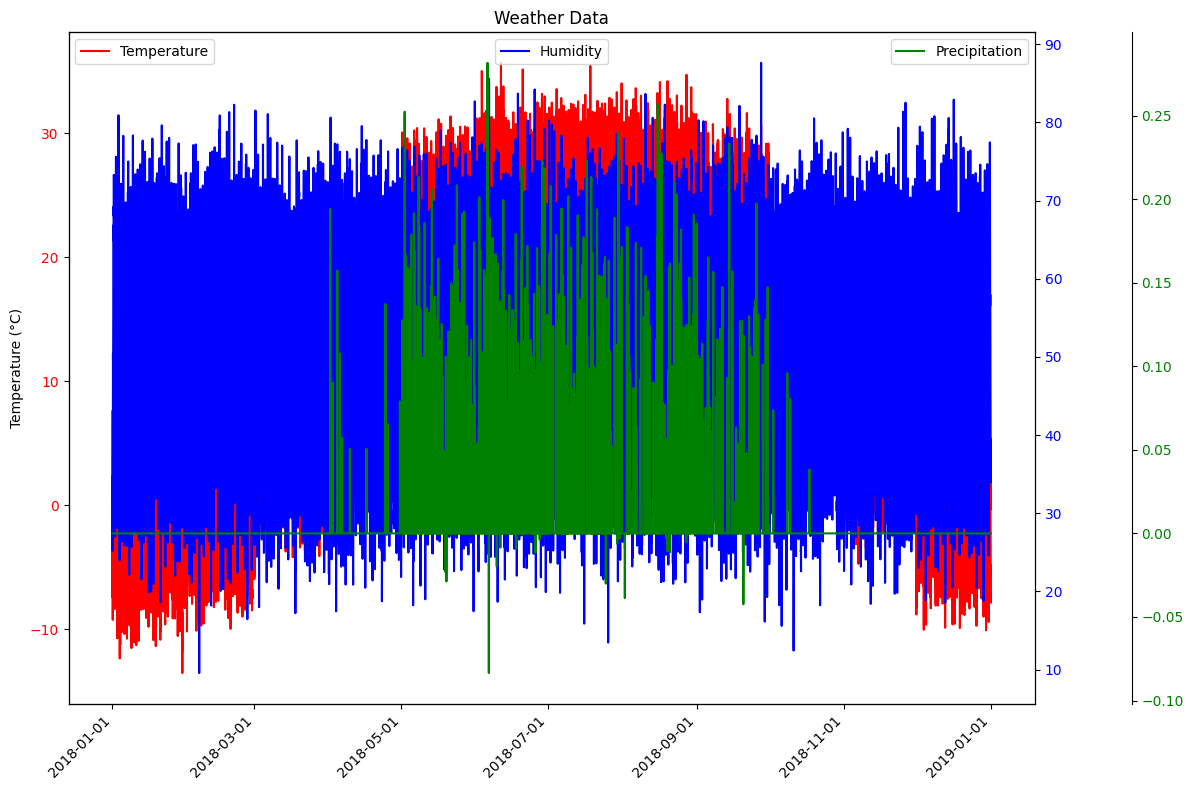

In [7]:
plot(weather_df, 'Weather Data')

In [10]:
def daily_average(weather_data):
    # Resample the dataframe to daily frequency and calculate mean for each day
    daily_data = weather_data.resample('D').mean()

    # Remove any NaN values that might have been introduced by the resampling operation
    daily_data = daily_data.dropna()

    return daily_data

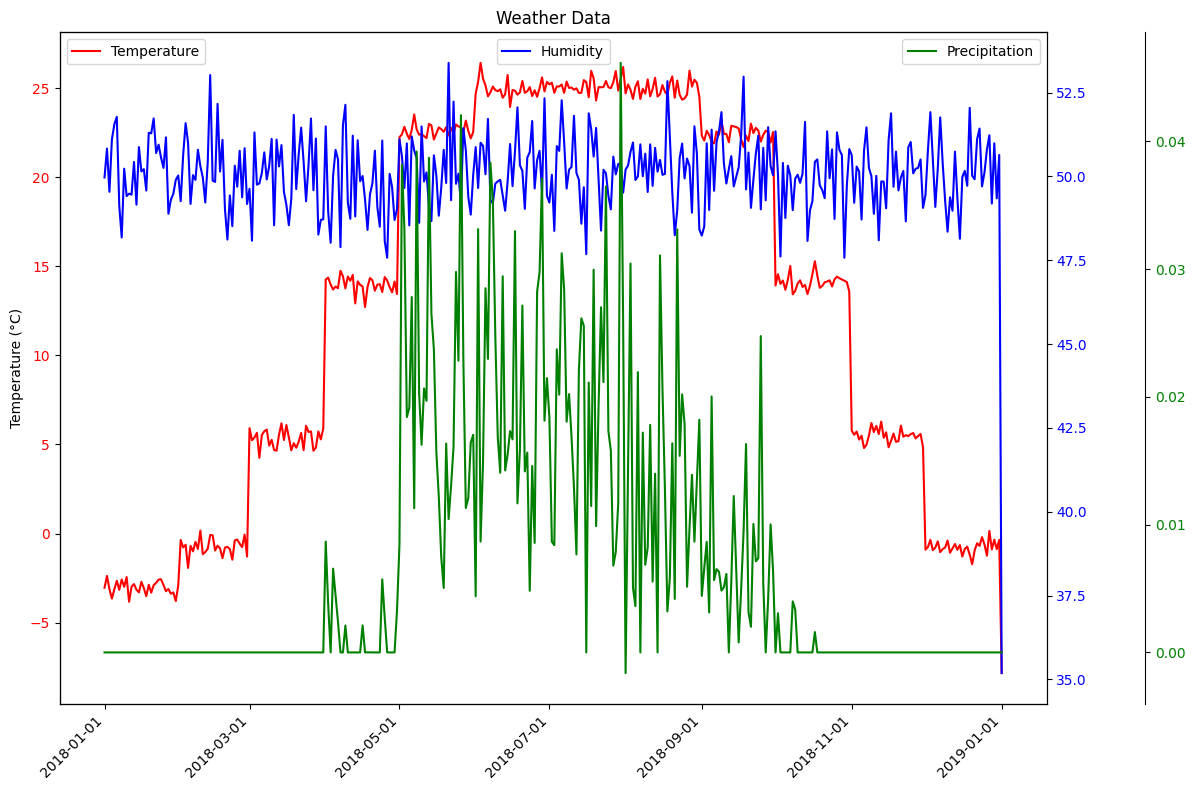

In [12]:
plot(daily_average(weather_df), 'Weather Data')

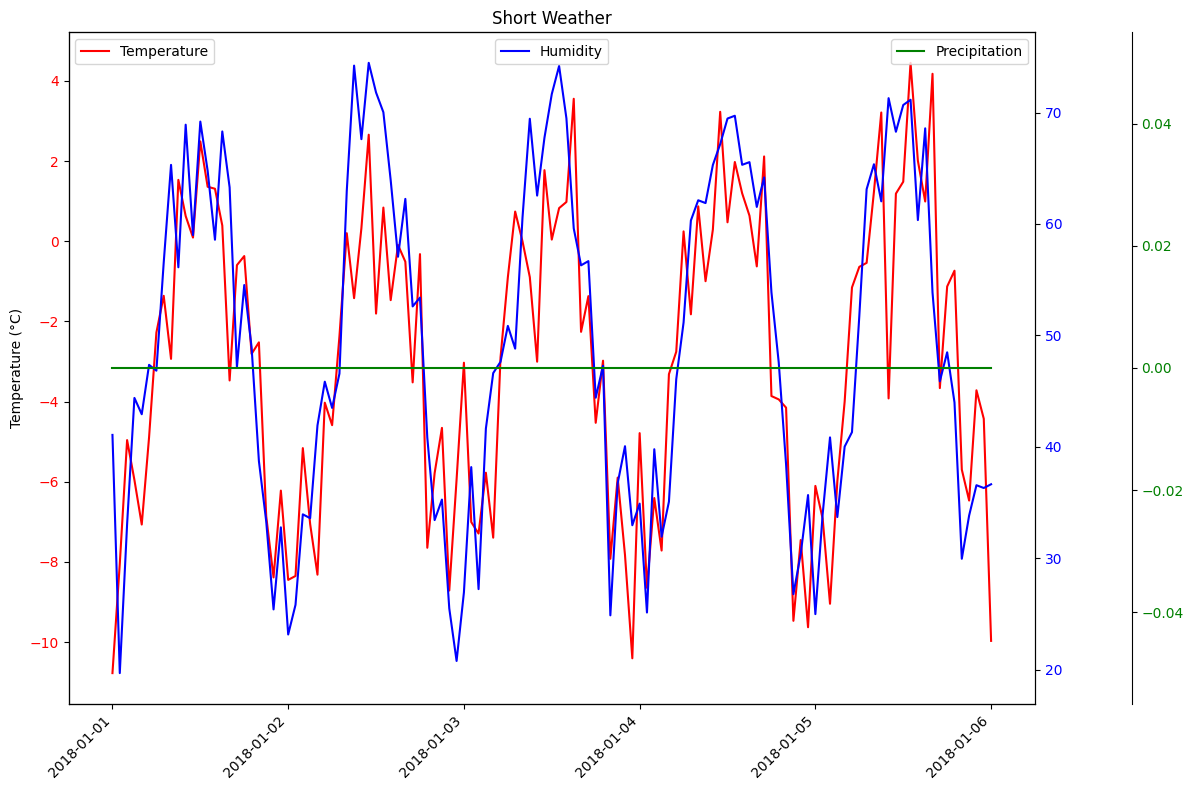

In [13]:
short_weather = generate_weather('2018-01-01', '2018-01-06')
plot(short_weather, 'Short Weather')

Improve our model with historical data for a location

In [14]:
cape_town_data = {
    'avg_temps': np.array([20, 20.1, 18.9, 16.9, 15.1, 13.6, 13, 13, 14, 15.7, 17.1, 19]),
    'avg_humidity': np.array([17, 16, 18, 50, 72, 112, 103, 90, 55, 36, 32, 20]),
    'avg_precipitation': np.array([73, 74, 75, 77, 80, 78, 77, 77, 74, 73, 72, 72])
}


lulea_data = {
    'avg_temps': np.array([-7.8, -7.9, -4.5, 0.6, 6.9, 12.2, 16.3, 15, 10.5, 3.9, -0.8, -4.6]),
    'avg_humidity': np.array([50, 37, 35, 34, 41, 57, 61, 68, 64, 60, 63, 58]),
    'avg_precipitation': np.array([86, 85, 81, 78, 69, 69, 73, 76, 78, 84, 86, 84])
}

In [19]:
def generate_weather_loc(start_date, end_date, location_data=None):
    # Create a time index with hourly frequency
    idx = pd.date_range(start_date, end_date, freq='H')

    # Extract months and hours for our calculations
    months = idx.month -1
    hours = idx.hour


    if location_data is not None:
        avg_temps = location_data['avg_temps']
        avg_humidity = location_data['avg_humidity']
        avg_precipitation = location_data['avg_precipitation']

        temp_seasonal = pd.Series(avg_temps[months], index=idx)
        hum_base = pd.Series(avg_humidity[months], index=idx)
        p_base = pd.Series(avg_precipitation[months] / 30 / 24, index=idx)
    else:
        temp_seasonal = pd.Series((np.sin(((months - 1) / 12 * 2 * np.pi) - (6 * (2 * np.pi) / 12 - (np.pi / 2))) * 17 +14), index=idx)
        temp_seasonal = temp_seasonal.clip(lower=-20, upper=25)
        hum_base = pd.Series(50, index=idx)
        p_base = pd.Series(0, index=idx)

    # Generate temperatures
    temp_diurnal = np.cos((hours - 12) / 24 * 2 * np.pi) * 5
    temp_noise = np.random.normal(0, 2, len(idx))

    temp = temp_seasonal + temp_diurnal + temp_noise

    # Generate humidity data with diurnal cycle and random noise
    hum_diurnal = np.sin((hours - 6) / 24 * 2 * np.pi) * 20
    hum_noise = np.random.normal(0, 5, len(idx))
    hum = hum_base + hum_diurnal + hum_noise

    # Generate precipitation data with random noise and higher probablility during summer
    p_seasonal = np.sin((months - 1) / 12 * 2 * np.pi) * 0.1 + 0.2
    p_summer = (temp > 20) & (np.random.rand(len(idx)) < p_seasonal)
    p_noise = np.random.normal(0, 0.05, len(idx))
    p = p_base + p_summer.astype(float) * (0.1  + p_noise)

    data = {
        'Temperature': temp,
        'Humidity': hum,
        'Precipitation': p
    }

    return pd.DataFrame(data, index=idx)

In [20]:
start_date = '2023-01-01'
end_date = '2024-01-01'
cape_town_weather = generate_weather_loc(start_date, end_date, cape_town_data)
lulea_weather = generate_weather_loc(start_date, end_date, lulea_data)

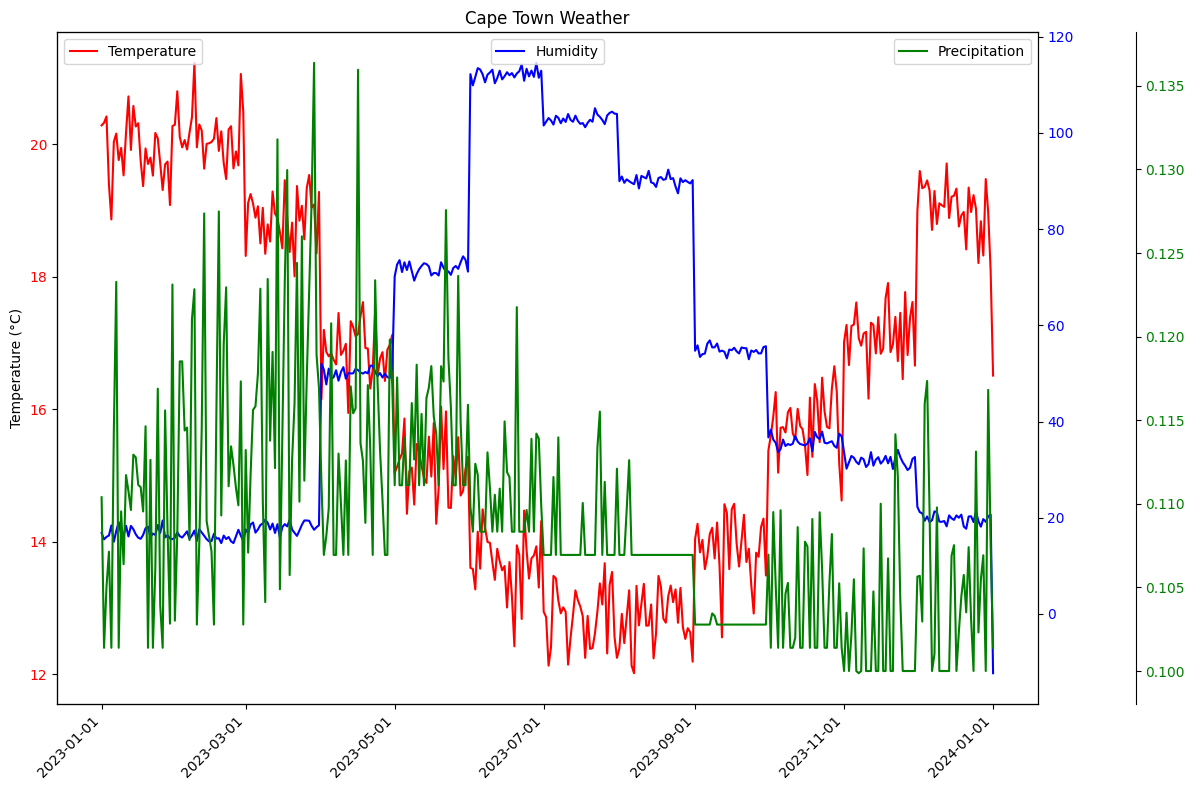

In [22]:
plot(daily_average(cape_town_weather), 'Cape Town Weather')

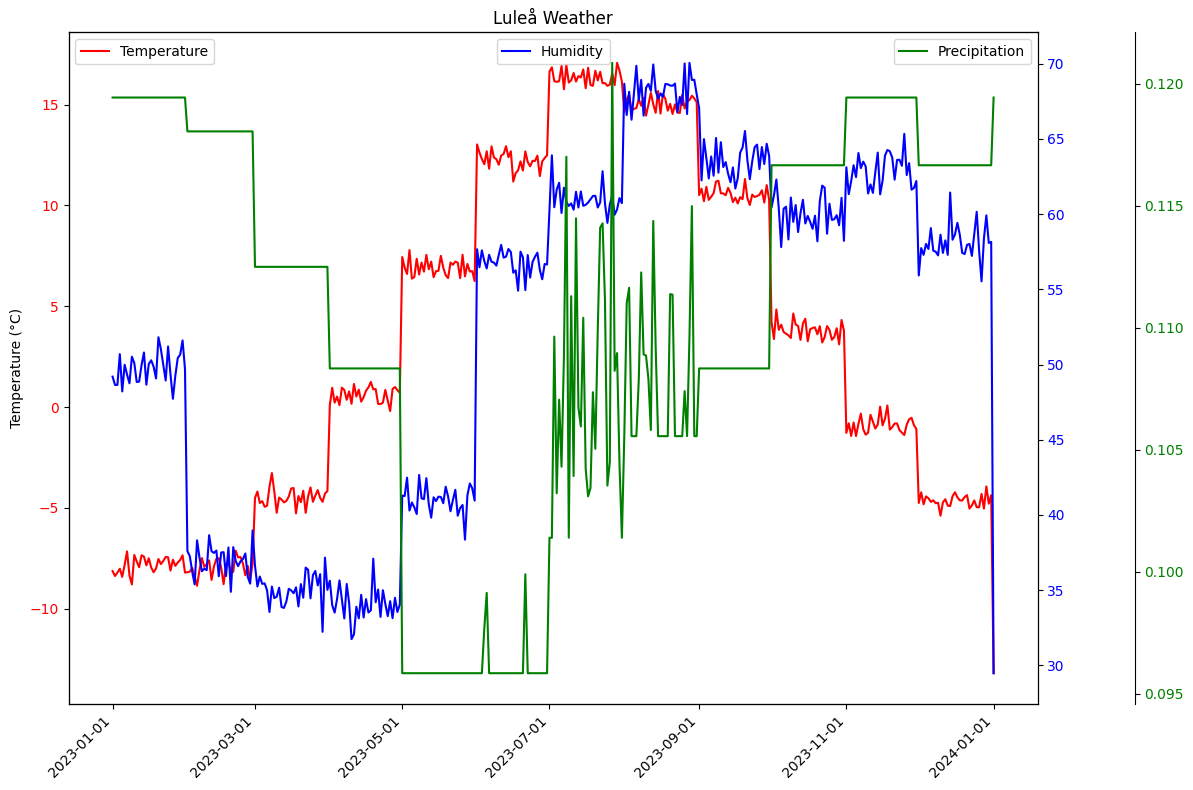

In [23]:
plot(daily_average(lulea_weather), 'Luleå Weather')